## Data

In [4]:
import torch
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

## Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


class CNN(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        
        # forward pass of feature extractor to calculate input size of fc1
        x = self.feature_extractor(torch.randn((1, *input_shape)))
        self.to_linear_shape =  x[0].shape[0] * x[0].shape[1] * x[0].shape[2]

        self.fc1 = nn.Linear(self.to_linear_shape, 128)   
        self.fc2 = nn.Linear(128, 10)
        
        for n, l in self.named_parameters():
            if l.dim() == 1:
                nn.init.constant_(l, 0.01)
            else:
                nn.init.kaiming_uniform_(l, mode='fan_in', nonlinearity='relu')
        

    def feature_extractor(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
                
        return x
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, self.to_linear_shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        
        return x
    
model = CNN((1, 28, 28))

## Training

In [49]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 3


def calc_acc(model, dataset):
    total = 0
    correct = 0

    for xb,yb in dataset:
        yb_hat = model(xb)
        yb_hat = torch.argmax(yb_hat, dim=-1)

        correct += (yb == yb_hat).sum().item()
        total += yb_hat.size()[0]
                
    return round(correct/total*100, 3), correct, total

print('starting accuracy', calc_acc(model, testset))

for epoch in range(epochs):
    for xb,yb in testset:
        model.zero_grad()
        output = model(xb)
        loss = F.nll_loss(output, yb)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch} --")
    print(loss.item())
    print(calc_acc(model, testset))

starting accuracy (11.35, 1135, 10000)
Epoch 0 --
-0.4000000059604645
(40.11, 4011, 10000)
Epoch 1 --
-0.4000000059604645
(47.49, 4749, 10000)
Epoch 2 --
-0.5
(47.64, 4764, 10000)


## Inference

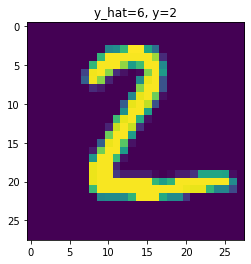

In [37]:
IDX = 1
with torch.no_grad():
    for xb,yb in testset:
        x = xb[IDX]
        y = yb[IDX]
        y_hat = model(x.unsqueeze(0))
        y_hat = torch.argmax(y_hat)

        plt.imshow(xb[IDX].view(28, 28))
        plt.title(f"y_hat={y_hat}, y={y}")
        break
    
    

## Training with ignite

In [43]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler, ParamGroupScheduler
from ignite.contrib.handlers.tensorboard_logger import *

In [45]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

epochs = 3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

lr_scheduler = CosineAnnealingScheduler(optimizer, "lr", start_value=1e-3, end_value=1e-5, cycle_size=20,start_value_mult=0.7)
schedulers = [lr_scheduler]
schedulers_names = ["lr"]
scheduler = ParamGroupScheduler(schedulers=schedulers, names=schedulers_names)



metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

trainer = create_supervised_trainer(model, optimizer, criterion)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    train_evaluator.run(trainset)
    validation_evaluator.run(testset)
    
def compute_metrics(engine):
    train_evaluator.run(trainset)
    validation_evaluator.run(testset)

tb_logger = TensorboardLogger(log_dir='/home/asdf/tensorboard')

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"batchloss": loss}, metric_names="all"
    ),
    event_name=Events.ITERATION_COMPLETED(every=100),
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(tag="training", metric_names=["loss", "accuracy"], another_engine=trainer),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    validation_evaluator,
    log_handler=OutputHandler(tag="validation", metric_names=["loss", "accuracy"], another_engine=trainer),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    trainer, log_handler=OptimizerParamsHandler(optimizer), event_name=Events.ITERATION_COMPLETED(every=100)
)

tb_logger.attach(trainer, log_handler=WeightsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=GradsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

trainer.run(trainset, max_epochs=epochs)
tb_logger.close()